In [70]:
import pandas as pd
import numpy as np

# Load members data
members_df = pd.read_csv('members_multiyear.csv', parse_dates=['join_date', 'cancel_date'])

# Load check-ins data
checkins_df = pd.read_csv('checkins_multiyear_24hr.csv', parse_dates=['checkin_date'])

In [71]:
# Preview members
print("Members:")
display(members_df.head())

# Preview check-ins
print("Check-ins:")
display(checkins_df.head())

Members:


,member_id,join_date,cancel_date,gender,age,zip_code,membership_type
0,M0001,2022-01-21,2022-05-12,Other,39,46201,Classic
1,M0002,2023-01-01,NaT,M,38,46203,Black Card
2,M0003,2024-12-27,NaT,Other,53,46203,Black Card
3,M0004,2023-07-27,NaT,F,41,46250,Black Card
4,M0005,2024-06-28,NaT,F,49,46203,Classic


Check-ins:


,checkin_id,member_id,checkin_date,checkin_time
0,C000001,M0001,2022-03-26,15:21:00
1,C000002,M0001,2022-03-29,05:24:00
2,C000003,M0001,2022-04-28,00:10:00
3,C000004,M0001,2022-05-05,05:43:00
4,C000005,M0001,2022-01-24,13:15:00


In [72]:
# How many members are in the dataset?
print("Total members:", members_df.shape[0])

# How many total check-ins?
print("Total check-ins:", checkins_df.shape[0])

# Check if any members have canceled
print("Canceled members:", members_df['cancel_date'].notna().sum())

Total members: 1500
Total check-ins: 205708
Canceled members: 256


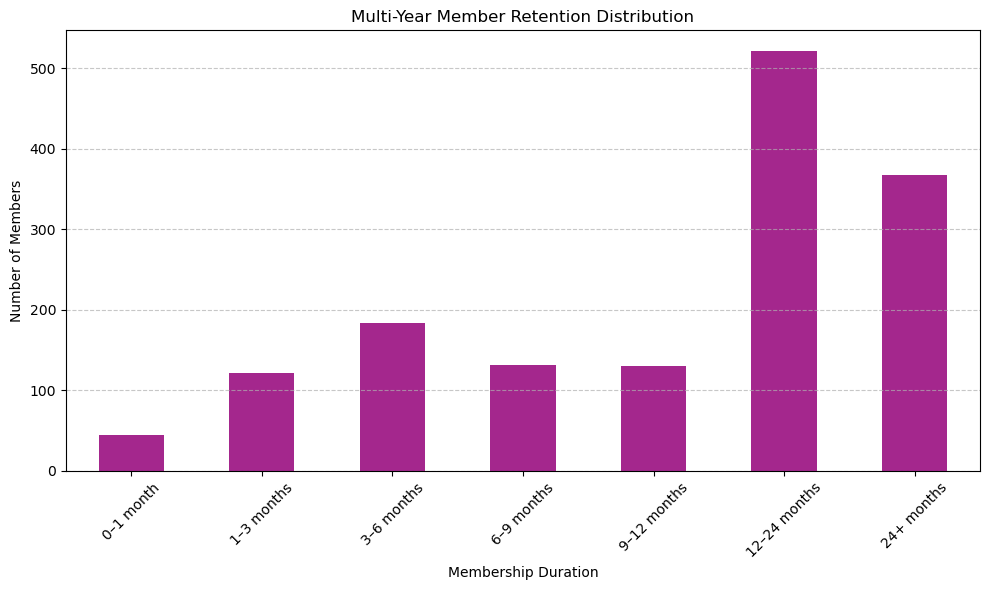

In [73]:
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap

# Example: Custom gradient from light purple to deep blue
custom_cmap = LinearSegmentedColormap.from_list(
    "pfit_brand_cmap",
    ["#FFFFFF", "#A4278D"]
)

# custom_cmap = LinearSegmentedColormap.from_list(
#    "my_brand_multi",
#    ["#FFE5F0", "#FFC2D9", "#C25FFF", "#4B0082"]  # Example brand palette
#)

# Define reference end date for still-active members
reference_date = pd.to_datetime('2024-12-31')
members_df['end_date'] = members_df['cancel_date'].fillna(reference_date)

# Calculate membership duration in days
members_df['membership_days'] = (members_df['end_date'] - members_df['join_date']).dt.days

# Define retention bins (including long-term members)
bins = [0, 30, 90, 180, 270, 365, 730, float('inf')]
labels = ['0–1 month', '1–3 months', '3–6 months', '6–9 months', '9–12 months', '12–24 months', '24+ months']
members_df['retention_bin'] = pd.cut(members_df['membership_days'], bins=bins, labels=labels, right=False)

# Count members in each bin
retention_counts = members_df['retention_bin'].value_counts().sort_index()

# Plot the retention distribution
plt.figure(figsize=(10, 6))
retention_counts.plot(kind='bar', color='#A4278D')
plt.title('Multi-Year Member Retention Distribution')
plt.xlabel('Membership Duration')
plt.ylabel('Number of Members')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


# Key Insights from Multi-Year Member Retention Distribution

### Now you can clearly see how many members have lasted:

- Over 12 months (long-term loyalists)

- 24+ months (very rare, high-value group)

### Early dropout groups (0–3 months) remain prominent — a typical pattern in fitness businesses.

#### This chart enables richer insights and storytelling about member longevity, program impact, and churn timing across multiple years.

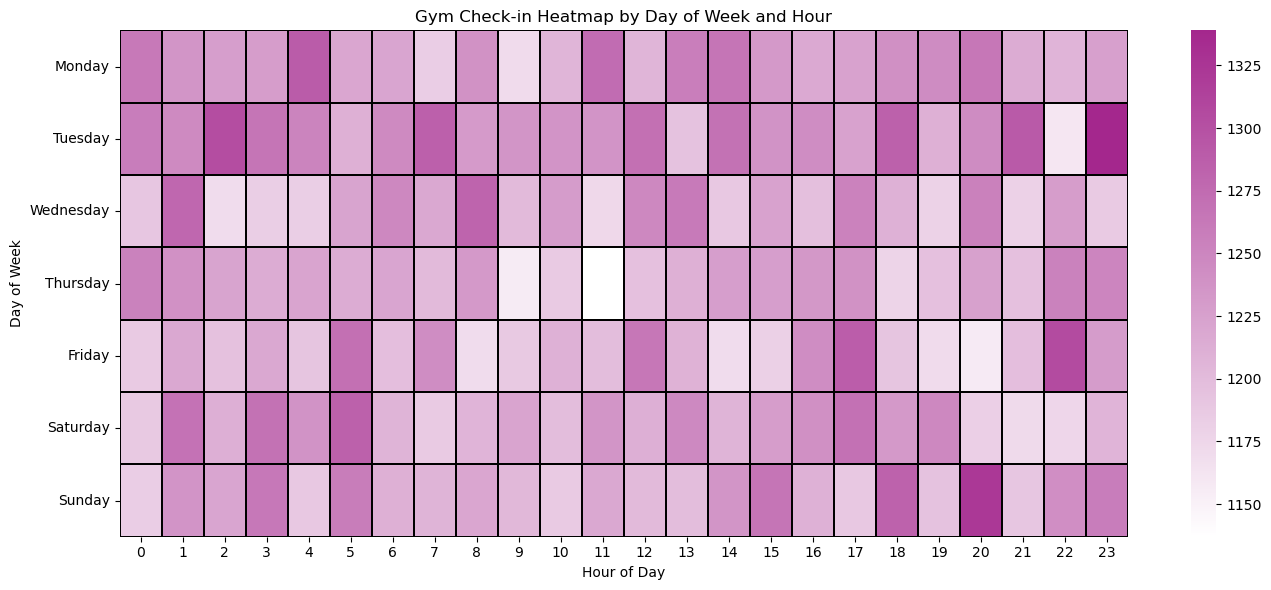

In [74]:
# Parse checkin_time and extract day of week and hour from check-in date and time
checkins_df['checkin_time'] = pd.to_datetime(checkins_df['checkin_time'], format='%H:%M:%S').dt.time
checkins_df['day_of_week'] = checkins_df['checkin_date'].dt.day_name()
checkins_df['hour'] = pd.to_datetime(checkins_df['checkin_time'].astype(str), format='%H:%M:%S').dt.hour


# Create a pivot table with count of check-ins by day and hour
heatmap_data = checkins_df.pivot_table(
    index='day_of_week',
    columns='hour',
    values='checkin_id',
    aggfunc='count'
)

# Optional: Reorder days to Monday → Sunday
days_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
heatmap_data = heatmap_data.reindex(days_order)

# Plot the heatmap
plt.figure(figsize=(14, 6))
sns.heatmap(heatmap_data, cmap=custom_cmap, linewidths=0.3, linecolor='#000000')
plt.title('Gym Check-in Heatmap by Day of Week and Hour')
plt.xlabel('Hour of Day')
plt.ylabel('Day of Week')
plt.tight_layout()
plt.show()

# 📌 Key Insights You Can Extract (24-Hour Version)
## 🕒 1. Peak Attendance Hours
### Likely early mornings (6–9 AM) and evenings (5–8 PM) — common before/after work.

These are ideal times for staffing, cleaning rotations, and equipment monitoring.

## 🌙 2. Late-Night and Early-Morning Usage
### With 24-hour data, you'll be able to see if there's a consistent 12 AM–5 AM crowd.

This can reveal usage by:

- Shift workers

- Night owls

- High-traffic urban gyms

#### This insight can help determine whether keeping all locations open 24/7 is cost-effective.

## 🗓️ 3. Weekday vs. Weekend Patterns
Weekdays tend to have sharp peaks (workday routines).

Weekends often show mid-morning surges (9–11 AM) and fewer late-night check-ins.

## 💡 4. Underused Hours
### Identify low-traffic times (e.g., 2–4 AM or mid-afternoons).

These could be good times for:

 - Deep cleaning

- Equipment maintenance

- Off-peak promotions

## 👥 5. Strategic Planning for Staffing & Services
### With a clear picture of hour-by-hour usage, Planet Fitness could:

- Optimize staffing schedules

- Offer classes or events during underused windows

- Justify reduced staffing during overnight hours (or conversely, enhance security if needed)

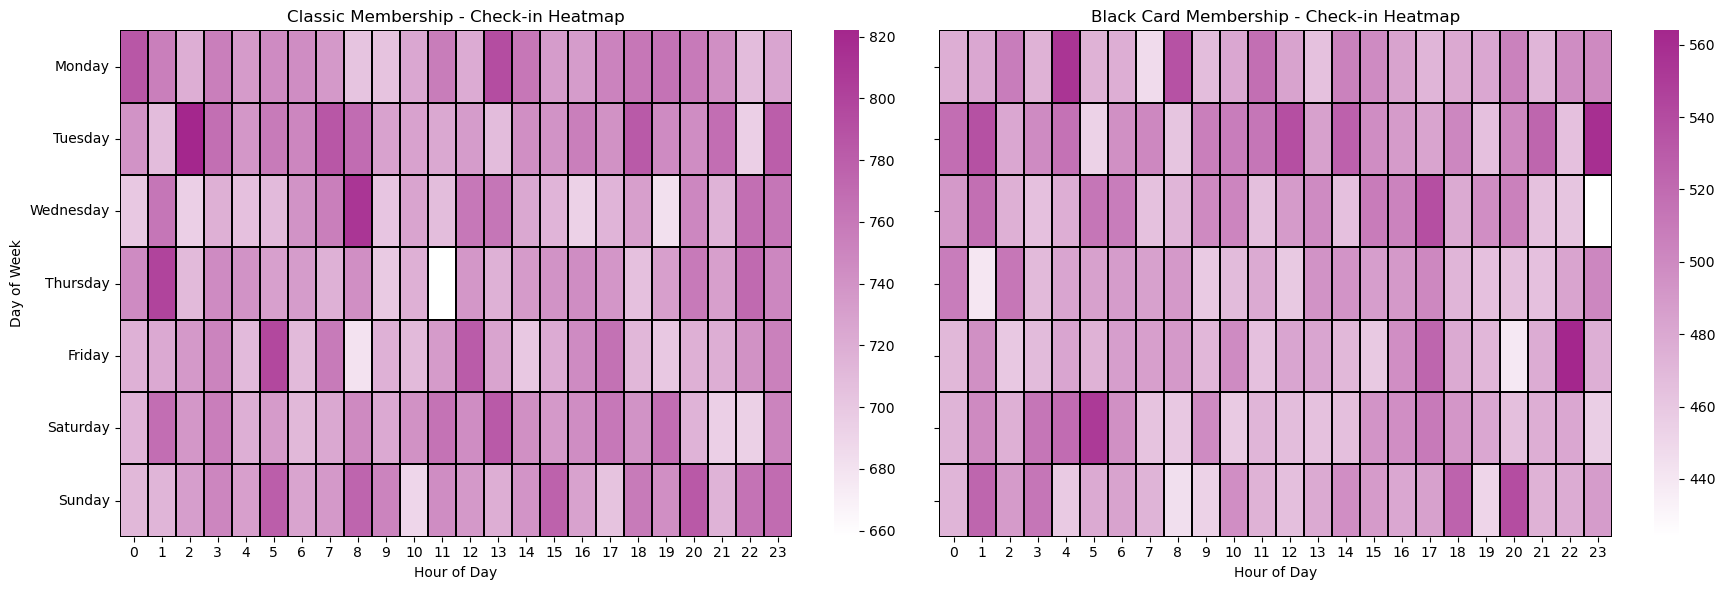

In [75]:
# Merge to include membership type
merged_df = checkins_df.merge(
    members_df[['member_id', 'membership_type']],
    on='member_id',
    how='left'
)

# Create pivot tables by membership type
classic_heatmap = merged_df[merged_df['membership_type'] == 'Classic'].pivot_table(
    index='day_of_week',
    columns='hour',
    values='checkin_id',
    aggfunc='count'
).reindex(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])

blackcard_heatmap = merged_df[merged_df['membership_type'] == 'Black Card'].pivot_table(
    index='day_of_week',
    columns='hour',
    values='checkin_id',
    aggfunc='count'
).reindex(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])

# Plot side-by-side heatmaps
fig, axes = plt.subplots(1, 2, figsize=(18, 6), sharey=True)

sns.heatmap(classic_heatmap, cmap=custom_cmap, linewidths=0.3, linecolor='#000000', ax=axes[0])
axes[0].set_title('Classic Membership - Check-in Heatmap')
axes[0].set_xlabel('Hour of Day')
axes[0].set_ylabel('Day of Week')

sns.heatmap(blackcard_heatmap, cmap=custom_cmap, linewidths=0.3, linecolor='#000000', ax=axes[1])
axes[1].set_title('Black Card Membership - Check-in Heatmap')
axes[1].set_xlabel('Hour of Day')
axes[1].set_ylabel('')

plt.tight_layout()
plt.show()

# 🔍 Observations You Can Explore:
## 💜 Classic Membership
- May show more structured time patterns (e.g., before/after work hours)

- Possibly more weekday-dominant attendance

## 🖤 Black Card Membership
- Potentially broader distribution of check-ins across more hours

- Might include more late-night or midday visits, thanks to 24/7 access and flexible perks (like multiple location access)

### This kind of breakdown helps identify how different member tiers use the gym differently, which can inform:

- Tier-specific marketing

- Premium staffing/service scheduling

- Usage-based loyalty rewards

# Churn Prediction Model

In [76]:
import pandas as pd
import numpy as np
from datetime import datetime
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

In [77]:
# Load members and check-ins datasets
members_df = pd.read_csv('members_multiyear.csv', parse_dates=['join_date', 'cancel_date'])
checkins_df = pd.read_csv('checkins_multiyear_24hr.csv', parse_dates=['checkin_date'])

In [78]:
# Create churn target variable
members_df['churned'] = members_df['cancel_date'].notna().astype(int)

# Merge to calculate check-ins within first 30 days
checkins_within_30 = checkins_df.merge(
    members_df[['member_id', 'join_date']],
    on='member_id',
    how='left'
)

# Days since member joined
checkins_within_30['days_since_join'] = (
    checkins_within_30['checkin_date'] - checkins_within_30['join_date']
).dt.days

# Filter check-ins in first 30 days
checkins_within_30 = checkins_within_30[checkins_within_30['days_since_join'] <= 30]

# Count check-ins per member in first 30 days
checkin_counts_30 = checkins_within_30.groupby('member_id').size().reset_index(name='checkins_first_30')

# Merge features with members data
features_df = members_df.merge(checkin_counts_30, on='member_id', how='left')
features_df['checkins_first_30'] = features_df['checkins_first_30'].fillna(0)

# Encode categorical features
features_df['membership_type'] = features_df['membership_type'].map({'Classic': 0, 'Black Card': 1})
features_df['join_month'] = features_df['join_date'].dt.month
features_df['age'] = features_df['age'].fillna(features_df['age'].median())

In [79]:
# Define features and target
X = features_df[['checkins_first_30', 'membership_type', 'join_month', 'age']]
y = features_df['churned']

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train Random Forest
model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [80]:
# Predict and evaluate
y_pred = model.predict(X_test)

# Print metrics
print("Classification Report:")
print(classification_report(y_test, y_pred))

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.95      0.90       252
           1       0.43      0.21      0.28        48

    accuracy                           0.83       300
   macro avg       0.65      0.58      0.59       300
weighted avg       0.79      0.83      0.80       300


Confusion Matrix:
[[239  13]
 [ 38  10]]


# 🧠 What These Metrics Mean (Based on Your Results)
## 🔹 Class 0 – Not Churned (Active Members)
- Precision: 0.86

When the model predicts that a member will stay, it’s correct 86% of the time.

- Recall: 0.95

The model correctly identifies 95% of all actual non-churned members.

### ✅ Conclusion:
Your model is very strong at identifying loyal, active members. It rarely misclassifies someone as a churn risk when they’re not.

## 🔸 Class 1 – Churned (Canceled Members)
- Precision: 0.43

When the model predicts a member will churn, it’s correct about 43% of the time.

- Recall: 0.21

The model only catches 21% of actual churned members — missing about 4 out of 5.

### ❌ Conclusion:
The model struggles to correctly identify most members who churn. It does flag some correctly, but it misses the majority.

## ⚖️ Overall Model Accuracy: 83%
The model correctly predicts member status in 83% of all test cases.
But keep in mind: this is largely driven by the high number of non-churned members (which dominate the data).

## 🔁 Confusion Matrix Breakdown

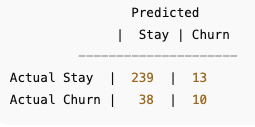

- ✅ 239 true positives: Correctly predicted active members

- ❌ 13 false positives: Predicted churn, but actually stayed

- ❌ 38 false negatives: Predicted stay, but actually churned

- ✅ 10 true positives (churn): Correctly predicted canceled members

## 💡 Summary Insight:
Your model is excellent at identifying members who will stay, and provides a decent early warning system for churn — but there’s room to grow if churn prediction is the primary business goal.